# Twitter Bot Detection: Classification Modeling


The goal of this project is to use machine learning classification models to detect whether a Twitter user is a bot based on account-level information (e.g. number of followers, number of tweets, etc.). This approach will *not* look at the actual contents of tweets. 

After exploring the data and identifying and engineering some potential features, I'll evaluate several classification models to find the best one for Twitter bot detection.

I'll be searching for models that have balanced scores between precision and recall and strong ROC AUC scores -- while I want the model to accurately label bots as often as possible, I also want to reduce misclassification and not simply label *everything* as a bot.

**Process**
1. Evaluate 'out-of-the-box' models and narrow down candidates to 2-3 models based on cross-validated scoring metrics.
2. Consider class-weight balancing (data is ~70/30 split human/bot)
3. Refine feature selection and tune candidate model parameters
4. Consider ensembling best models with VotingClassifier model
5. Pick best model, and perform full train and test
6. Train best model on full data set and pickle to be used in Flask app

In [1]:
# Basics
import pandas as pd
import psycopg2 as pg
import numpy as np
import pickle

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from model_evaluation import *

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model support
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, 
                             precision_recall_curve)

## Data import and set up

Importing data from SQL database and setting up features/interactions from EDA notebook to be used in modeling

In [2]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',             # Connecting to _local_ version of psql
    'dbname': 'twitter_accounts',    # DB with Twitter info
    'port': 5432                     # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [3]:
raw_df = pd.read_sql('SELECT * FROM human_bots', connection)

In [4]:
# drop funny index column
raw_df.drop(columns=['index'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [5]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'acct_location', 'geo_enabled', 'lang', 
             'default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 
             'statuses_count', 'average_tweets_per_day', 'account_age_days']]

In [6]:
del raw_df

In [7]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_friends'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_favorites'] = np.round((df['followers_count'] / df['account_age_days']), 3)

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible interactive features
df['network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1 + df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

In [8]:
df.head()

,bot,screen_name,created_at,hour_created,verified,acct_location,geo_enabled,lang,default_profile,default_profile_image,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,unknown,0,en,0,0,...,1.133,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,Estados Unidos,0,en,0,0,...,0.624,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.494
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,"Los Angeles, CA",1,en,0,0,...,0.148,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,0.414
3,0,TinkerVHELPK5,2016-07-21 13:32:25,13,0,"Birmingham, AL",1,en,1,0,...,0.347,6.452,6.250,9.040,0.636,40.325,44.932,0.298,0.354,0.354
4,0,JoleonLescott,2012-01-15 16:32:35,16,1,"England, United Kingdom",1,en,0,0,...,240.178,4.762,13.533,4.489,0.850,64.444,112.911,5.486,0.036,0.036


First round of feature selection - these should be accessible by all modeling types.

In [9]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [10]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

## Basic model evaluation

**Models to be evaluated**
* KNearestNeighbors
* LogisticRegression
* NaiveBayes (Gaussian, Bernoulli, Multinomial)
* DecicionTree
* RandomForest
* XGBoost

In [11]:
# Models that require scaling: 
knn = KNeighborsClassifier(n_neighbors=10)
lr = LogisticRegression()

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)

model_list = [knn, lr]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [12]:
multi_model_eval(model_list, X_train_scaled, y, kf)

Model: KNeighborsClassifier(n_neighbors=10)
------------------------------
Accuracy:  0.83767 +- 0.004042
Precision: 0.80131 +- 0.006912
Recall:    0.68362 +- 0.013989
F1 Score:  0.73768 +- 0.006909
ROC AUC:   0.89569 +- 0.003649

Model: LogisticRegression()
------------------------------
Accuracy:  0.80314 +- 0.002075
Precision: 0.71114 +- 0.006977
Recall:    0.69157 +- 0.010010
F1 Score:  0.70113 +- 0.003798
ROC AUC:   0.85181 +- 0.002741



In [13]:
# Models that don't require scaling
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

model_list = [gnb, bnb, mnb, tree, forest, xgb]
kf = KFold(n_splits=3, shuffle=True, random_state=33)

In [14]:
multi_model_eval(model_list, X, y, kf)

Model: GaussianNB()
------------------------------
Accuracy:  0.69503 +- 0.059328
Precision: 0.55385 +- 0.090251
Recall:    0.82332 +- 0.138664
F1 Score:  0.64431 +- 0.011958
ROC AUC:   0.82068 +- 0.002617

Model: BernoulliNB()
------------------------------
Accuracy:  0.74124 +- 0.003394
Precision: 0.69436 +- 0.006968
Recall:    0.40249 +- 0.010015
F1 Score:  0.50949 +- 0.007802
ROC AUC:   0.80215 +- 0.000312

Model: MultinomialNB()
------------------------------
Accuracy:  0.46963 +- 0.003039
Precision: 0.38474 +- 0.002703
Recall:    0.98151 +- 0.003564
F1 Score:  0.55279 +- 0.002419
ROC AUC:   0.59444 +- 0.000558

Model: DecisionTreeClassifier()
------------------------------
Accuracy:  0.80951 +- 0.002601
Precision: 0.71052 +- 0.002434
Recall:    0.72499 +- 0.005602
F1 Score:  0.71768 +- 0.003801
ROC AUC:   0.78842 +- 0.003250

Model: RandomForestClassifier()
------------------------------
Accuracy:  0.86835 +- 0.002722
Precision: 0.84612 +- 0.007291
Recall:    0.74069 +- 0.010617


RandomForest and XGBoost seem most promising in terms of balance between Precision and Recall metrics and high ROC AUC scores. 

Next I'll plot out the Precision-Recall and ROC Curves for each under KFolds cross-validation.

Average AUC Score: 0.9256 +- 0.004018


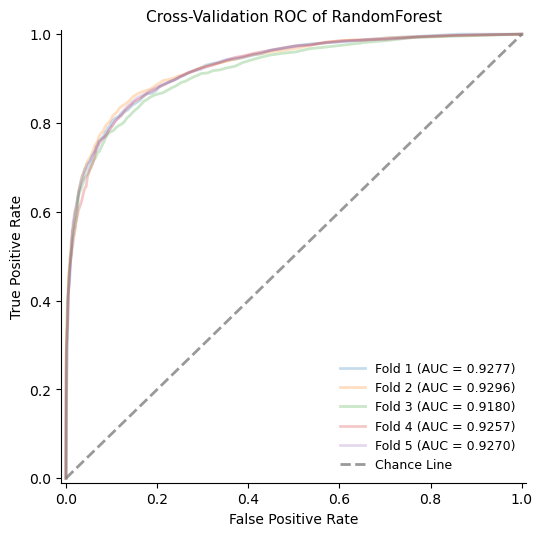

In [15]:
forest = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average Precision Score: 0.8475 +- 0.010672
Average Recall Score: 0.7428 +- 0.007557


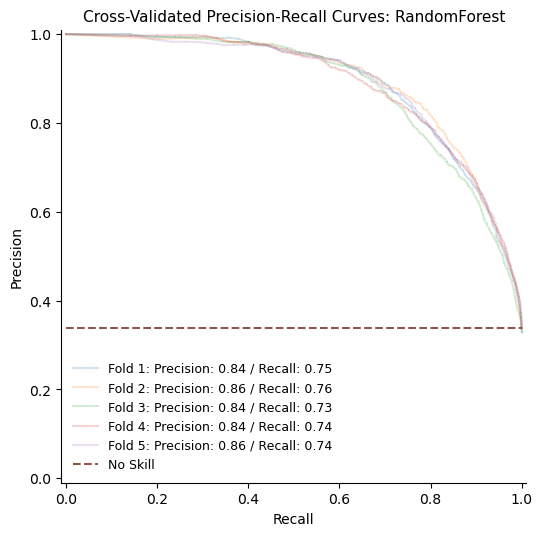

In [16]:
precision_recall_cv(forest, X, y, kf, model_alias='RandomForest')

Average AUC Score: 0.9274 +- 0.004188


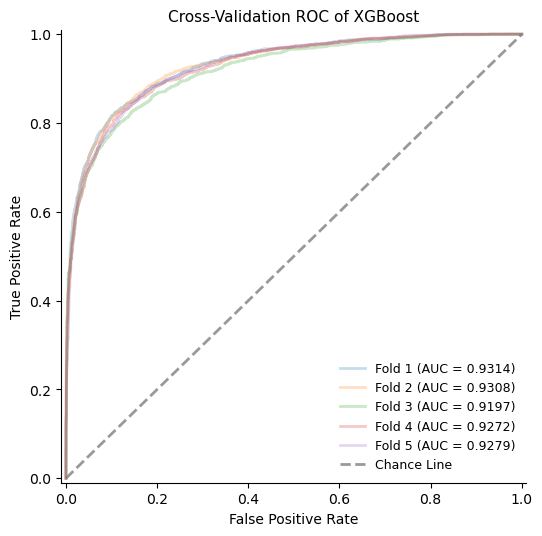

In [17]:
xgb = XGBClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.8417 +- 0.008911
Average Recall Score: 0.7526 +- 0.009472


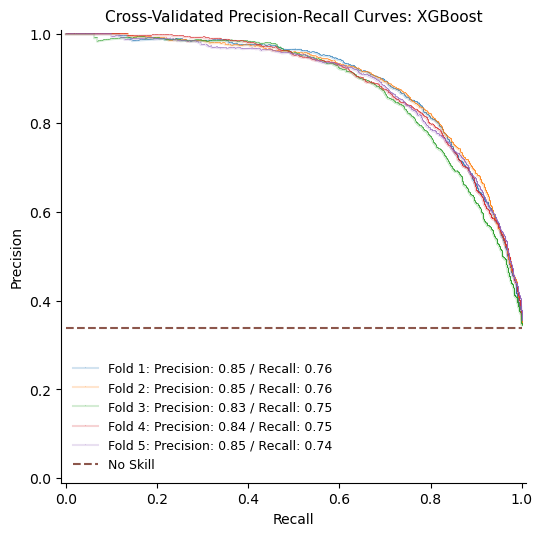

In [18]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

XGBoost has a slight edge, but I think it's too close to call with the out of the box models. Next I'll see what kind of effect rebalancing class weights has on the models.

## Class weight balancing

In [19]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print(f'Bots / Total %: {(num_bots / len(df))*100:.2f}')

Number of bots:  12425
Number of humans:  25013
Bots / Total %: 33.19


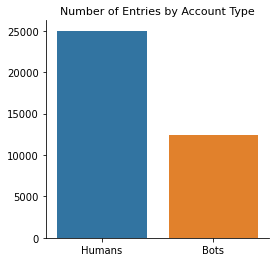

In [20]:
types = ['Humans', 'Bots']
counts = [num_humans, num_bots]

plt.figure(figsize=(4, 4))
sns.barplot(x = types, y = counts)
plt.title("Number of Entries by Account Type", fontsize=11)
sns.despine();

In [21]:
# For XGBoost
estimate = num_humans/num_bots
estimate

2.013118712273642

In [22]:
forest = RandomForestClassifier(class_weight='balanced')
xgb = XGBClassifier(scale_pos_weight=estimate)

models = [forest, xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [23]:
multi_model_eval(models, X, y, kf)

Model: RandomForestClassifier(class_weight='balanced')
------------------------------
Accuracy:  0.86946 +- 0.003454
Precision: 0.85310 +- 0.010391
Recall:    0.73585 +- 0.008267
F1 Score:  0.79009 +- 0.006605
ROC AUC:   0.92606 +- 0.003232

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.013118712273642,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
------------------------------
Accuracy:  0.86152 +- 0.004743
Precision: 0.78358 +- 0.009921
Recall:    0.80858 +- 0.007697
F1 Score:  0.79

RandomForest doesn't change that much but XGBoost's Recall score jumped past Precision while remaining fairly balanced.

Let's look at a the curves.

### Cross-Validated Precision-Recall and ROC Curves

#### RandomForest

Average AUC Score: 0.9264 +- 0.003299


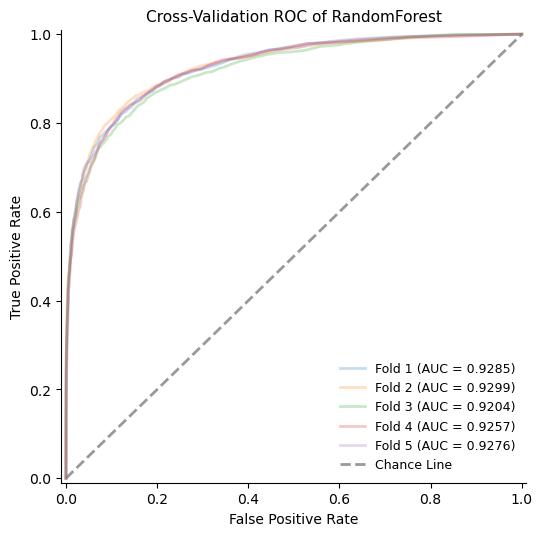

In [24]:
roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average Precision Score: 0.8522 +- 0.014144
Average Recall Score: 0.7364 +- 0.008185


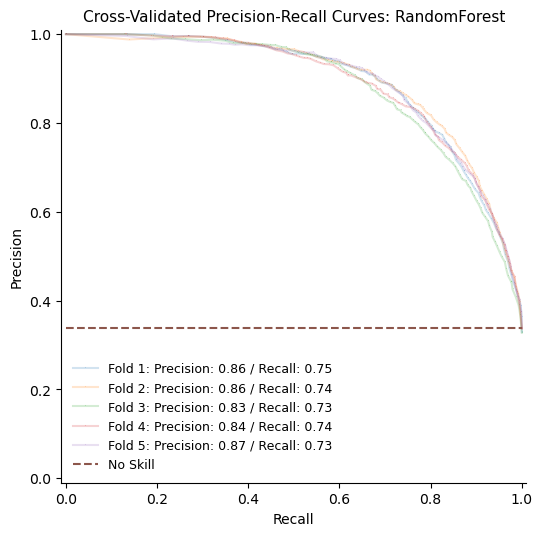

In [25]:
precision_recall_cv(forest, X, y, kf, model_alias='RandomForest')

#### XGBoost

Average AUC Score: 0.9262 +- 0.004222


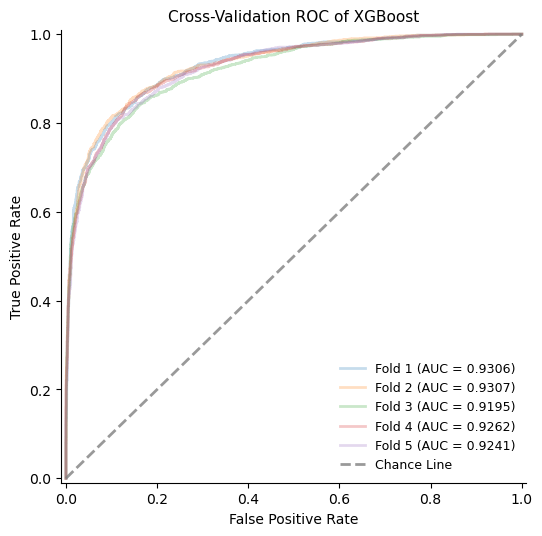

In [26]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.7836 +- 0.009921
Average Recall Score: 0.8086 +- 0.007697


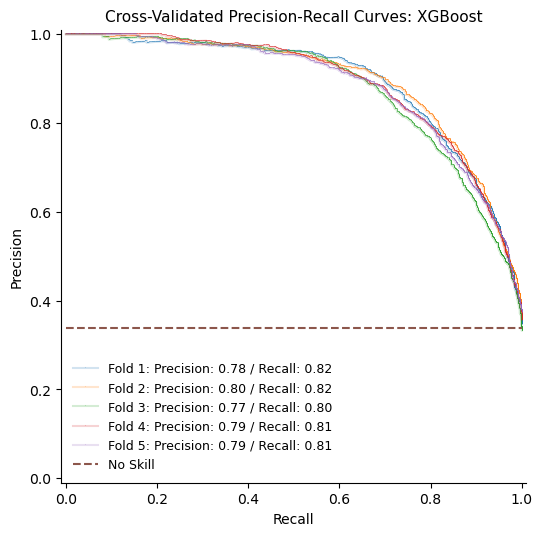

In [27]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

### Confusion Matrices

Let's take a look at the confusion matrices of each model for a single train/test split.

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3333)

#### RandomForest

In [29]:
forest = RandomForestClassifier(class_weight='balanced')

forest.fit(X_train, y_train)
preds = forest.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8674
Precision: 0.8405
Recall:    0.7323
F1 Score:  0.7827

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4415
           1       0.84      0.73      0.78      2137

    accuracy                           0.87      6552
   macro avg       0.86      0.83      0.84      6552
weighted avg       0.87      0.87      0.86      6552




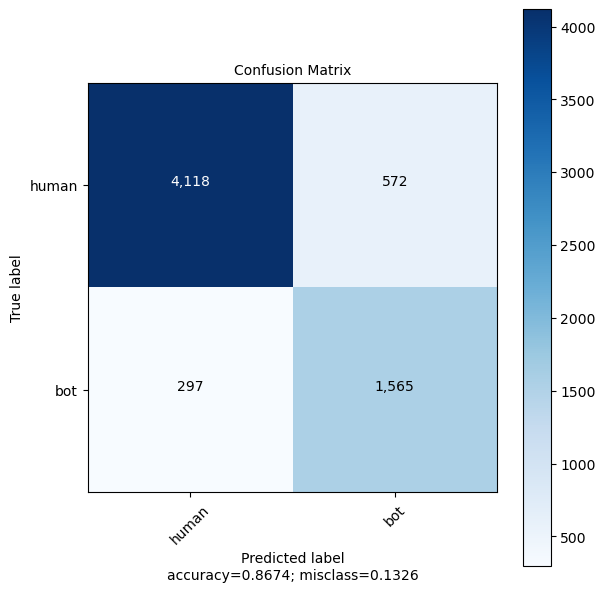

In [30]:
metrics_report(preds, y_val)

#### XGBoost

In [31]:
xgb = XGBClassifier(scale_pos_weight=estimate)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8571
Precision: 0.7723
Recall:    0.7969
F1 Score:  0.7844

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4415
           1       0.77      0.80      0.78      2137

    accuracy                           0.86      6552
   macro avg       0.84      0.84      0.84      6552
weighted avg       0.86      0.86      0.86      6552




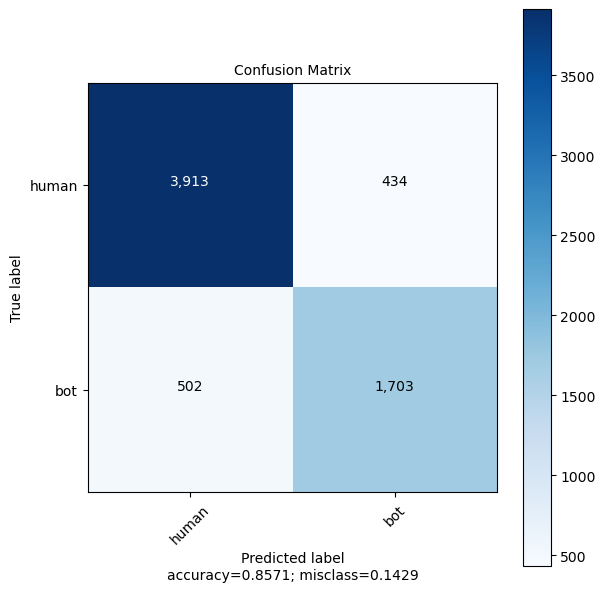

In [32]:
metrics_report(preds, y_val)

### Feature Importance

How does each model use the features? 

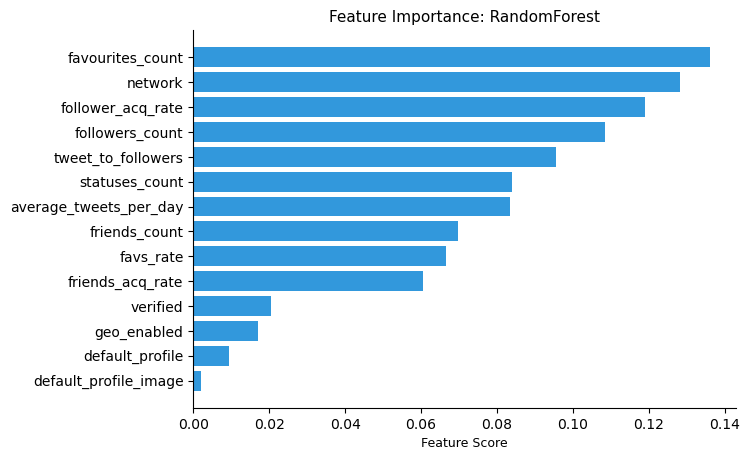

In [33]:
plot_feature_importance(forest, features, model_alias='RandomForest')

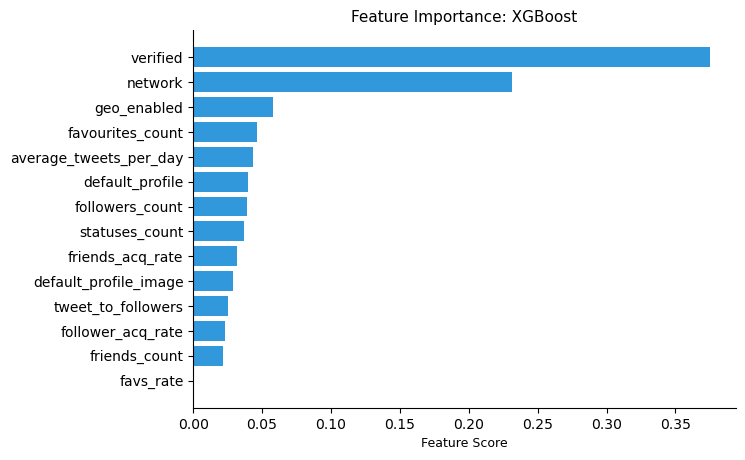

In [34]:
plot_feature_importance(xgb, features, model_alias='XGBoost')

It's actually quite interesting how each model uses the features! Network is important for both, but the rest is pretty scattered. Favourites count seems pretty important in both, so does average tweets per day. I'm surprised that RandomForest doesn't have verified as more important.

What's also interesting to note is that the feature scores in RandomForest are much more even than XGBoost - where network and verified are very high and the rest are much smaller.

If I had to pick one model right now, it'd be XGBoost based on the better balance between precision and recall. I still want to take another look at features, continue to tune model parameters, and possibly ensembling RandomForest and XGBoost to create a super model. 

## Continued Tuning and Feature Selection

In [35]:
df.head(3)

,bot,screen_name,created_at,hour_created,verified,acct_location,geo_enabled,lang,default_profile,default_profile_image,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,unknown,0,en,0,0,...,1.133,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,Estados Unidos,0,en,0,0,...,0.624,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.494
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,"Los Angeles, CA",1,en,0,0,...,0.148,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,0.414


In [36]:
features = ['verified', 
            #'created_at',
            'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            #'favs_rate'
           ]

X = df[features]
y = df['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

### Finding the best XGBoost Model

In [37]:
xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

model_list = [xgb]

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0.05,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)
------------------------------
Accuracy:  0.86869 +- 0.005360
Precision: 0.80354 +- 0.009730
Recall:    0.80312 +- 0.009279
F1 Score:  0.80331 +- 0.008852
ROC AUC:   0.93102 +- 0.003795



I think these are pretty solid scores and this is the most balanced version of the model I've been able to come up with thus far. Let's take a look at the curves. 

Average AUC Score: 0.9310 +- 0.003795


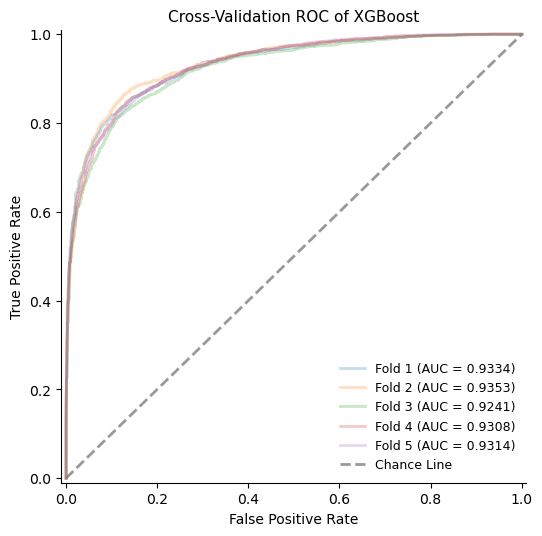

In [39]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.8035 +- 0.009730
Average Recall Score: 0.8031 +- 0.009279


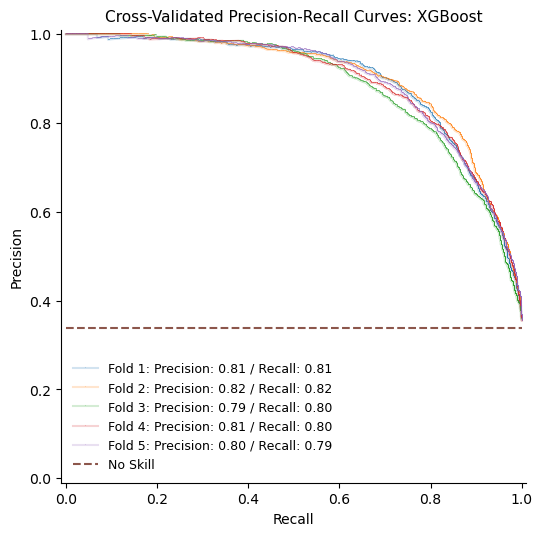

In [40]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

I like these scores a lot. Still, let's try ensembling RandomForest with XGBoost.

### Ensembling with VotingClassifier

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=1234)

In [42]:
forest = RandomForestClassifier(class_weight='balanced')
forest = forest.fit(X_train, y_train)

xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

xgb = xgb.fit(X_train, y_train)

In [43]:
models = [('forest', forest), ('xgb', xgb)]

voting_classifier = VotingClassifier(estimators=models,
                                     voting='soft',
                                     n_jobs=-1)

voting_classifier = voting_classifier.fit(X_train, y_train)

Classification Metrics Report
-----------------------------
Accuracy:  0.8678
Precision: 0.8225
Recall:    0.7623
F1 Score:  0.7912

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      5279
           1       0.82      0.76      0.79      2583

    accuracy                           0.87      7862
   macro avg       0.86      0.84      0.85      7862
weighted avg       0.87      0.87      0.87      7862




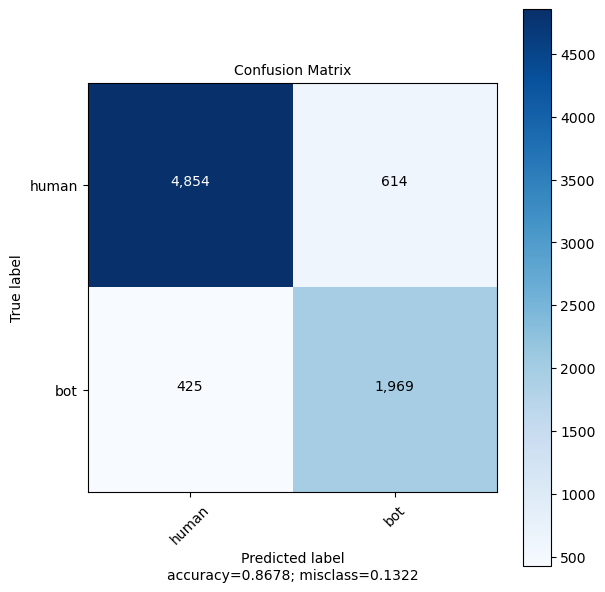

In [44]:
voting_classifier_prediction = voting_classifier.predict(X_val)

metrics_report(voting_classifier_prediction, y_val)

Worse! 

It's decided - XGBoost is the winning model.

## Best XGBoost Model: Full Train & Test and Results

Now to train the model on the full training data and test on the hold out set.

In [45]:
# Full train & test
best_model = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

In [46]:
best_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0.05,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

Classification Metrics Report
-----------------------------
Accuracy:  0.8770
Precision: 0.8136
Recall:    0.8091
F1 Score:  0.8114

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      7559
           1       0.81      0.81      0.81      3673

    accuracy                           0.88     11232
   macro avg       0.86      0.86      0.86     11232
weighted avg       0.88      0.88      0.88     11232




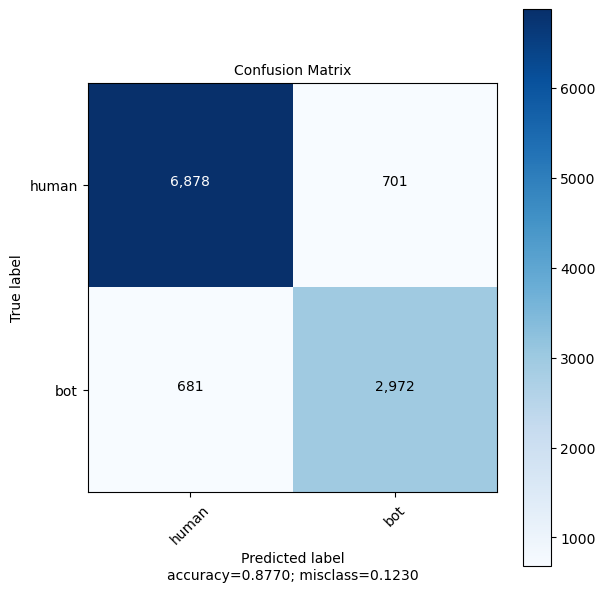

In [47]:
best_model_prediction = best_model.predict(X_test)

metrics_report(best_model_prediction, y_test)

ROC AUC score: 0.9336



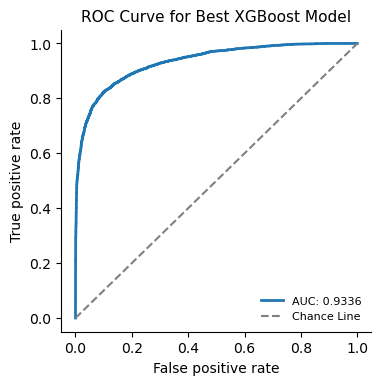

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

model_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(fpr, tpr,lw=2, label=f'AUC: {model_auc:.4f}')
plt.plot([0,1],[0,1],c='grey',ls='--', label='Chance Line')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=10)
plt.ylabel('True positive rate', fontsize=10)
plt.title('ROC Curve for Best XGBoost Model', fontsize=11)
plt.legend(loc='lower right', prop={'size': 8}, frameon=False)
sns.despine()
print(f'ROC AUC score: {model_auc:.4f}')
print("")
plt.show();

Precision score: 0.8136
Rcall score: 0.8091



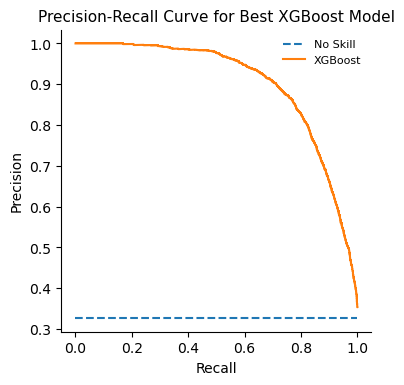

In [49]:
# Prec Recal Curve here

model_precision, model_recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:,1])

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(4, 4), dpi=100)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(model_recall, model_precision, marker=',', label='XGBoost')
# axis labels
plt.title('Precision-Recall Curve for Best XGBoost Model', fontsize=11)
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
# show the legend
plt.legend(loc='upper right', prop={'size': 8}, frameon=False)
# show the plot
sns.despine()

pred = best_model.predict(X_test)
prec_score = precision_score(y_test, pred)
rec_score = recall_score(y_test, pred)

print(f'Precision score: {prec_score:.4f}')
print(f'Rcall score: {rec_score:.4f}')
print("")

These are even better than the CV training scores! 

Literally every metric improved: 

```
Metric     |  CV Score |  Test Score
-----------+-----------+------------
Accuracy:  |   0.8687  |   0.8770
Precision: |   0.8035  |   0.8136
Recall:    |   0.8031  |   0.8091
F1 Score:  |   0.8033  |   0.8144
ROC AUC:   |   0.9310  |   0.9336
```    

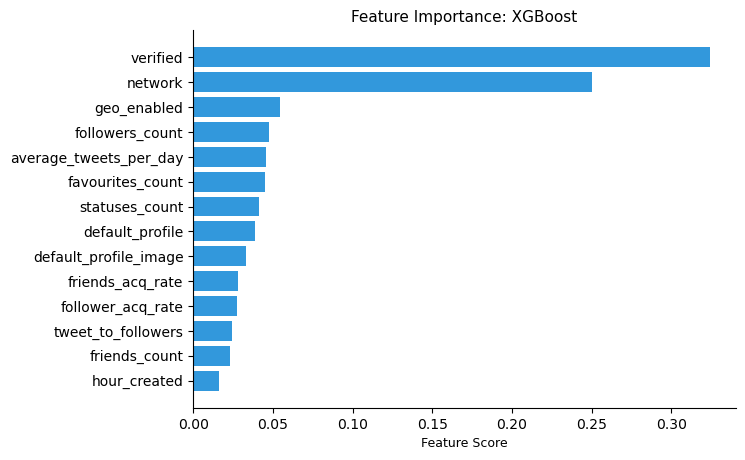

In [50]:
plot_feature_importance(best_model, features, model_alias='XGBoost')

Interestingly enough, the model switched Network and Verification statuses in the feature importance rankings. 

## Train model on the data dataset to use for new predictions

Now to train the model on the full dataset and pickle it for later use to make predictions on live Twitter users using their API.

In [51]:
features = ['verified', 
            'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
           ]

X = df[features]
y = df['bot']

In [52]:
fully_trained_model = XGBClassifier(scale_pos_weight=1.8, 
                                    tree_method='hist', 
                                    learning_rate=0.1,           
                                    eta=0.01,                 
                                    max_depth=7,                
                                    gamma=0.05,
                                    n_estimators=200,
                                    colsample_bytree=.8
                                   )

fully_trained_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0.05,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

Save as pickle to use later!

In [53]:
# with open('flask_app/model.pickle', 'wb') as to_write:
#    pickle.dump(fully_trained_model, to_write)